# Initialization

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql.functions import mean, col, desc, count, isnull, isnan, when, rank, sum
import pandas as pd
import matplotlib.pyplot as plt


spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

bank_file = "../Tamrin 5/ML_hw_dataset.csv"

bank = spark.read.csv(bank_file, header=True, inferSchema=True)

numeric_columns = [column for column, type in bank.dtypes if type == 'int' or type == 'double']
string_columns = [column for column in bank.columns if bank.schema[column].dataType == StringType()]


# Data cleaning

## Duplicate values

In [2]:
bank_count = bank.count()
print('Number of rows:', bank_count)

bank = bank.distinct()
bank_count_distinct = bank.count()
print('Number of dinstinct rowns:', bank_count_distinct)
print('Removed {} duplicate rows'.format(bank_count - bank_count_distinct))

Number of rows: 41188
Number of dinstinct rowns: 41176
Removed 12 duplicate rows


## Missing values

In [3]:
# columns_with_unknown = ['job', 'marital', 'education', 'default', 'housing', 'loan']

# # Drop unknown values
# for column in columns_with_unknown:
#     bank = bank.filter(col(column) != 'unknown')


## Outliers

Number of rows without outliers: 35006
Removed 6170 outliers


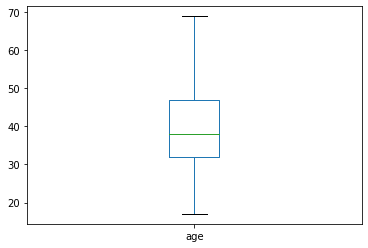

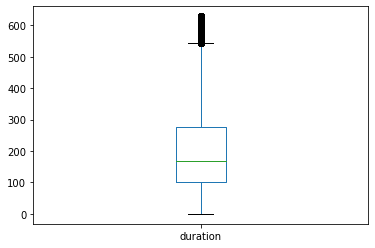

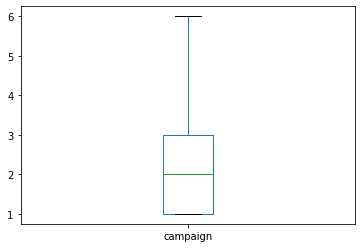

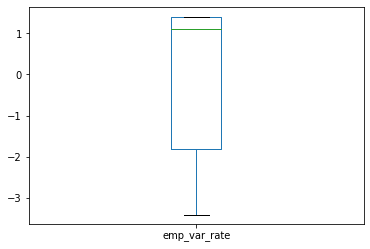

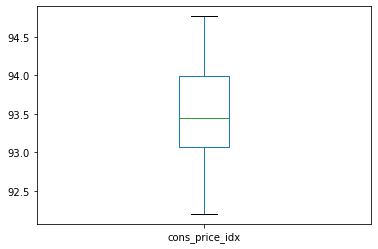

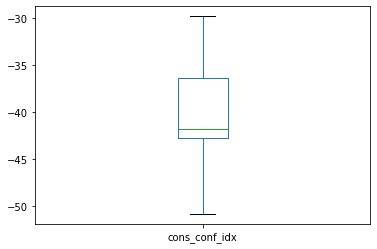

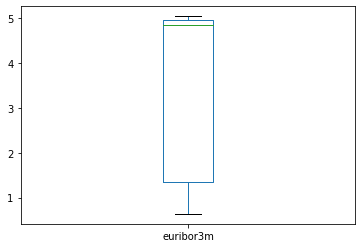

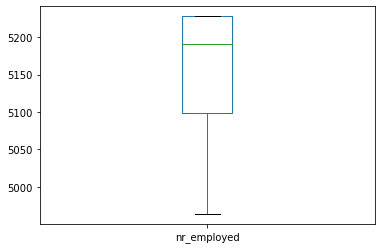

In [4]:
for column in ['age', 'duration', 'campaign', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']:
    Q1, Q3 = bank.approxQuantile(column, [0.25, 0.75], 0.01)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    higher_whisker = Q3 + 1.5 * IQR
    min_box = bank.withColumn(column, when(col(column) < lower_whisker, None).otherwise(col(column))).selectExpr(f"min({column})").collect()[0][0]
    max_box = bank.withColumn(column, when(col(column) > higher_whisker, None).otherwise(col(column))).selectExpr(f"max({column})").collect()[0][0]

    # Drop outliers
    bank = bank.withColumn(column, when((col(column) < lower_whisker) | (col(column) > higher_whisker), None).otherwise(col(column)))

    # Replace outliers with min/max boxplot values
    # bank = bank.withColumn(column, when((col(column) < lower_whisker), min_box).otherwise(col(column)))
    # bank = bank.withColumn(column, when((col(column) > higher_whisker), max_box).otherwise(col(column)))

bank = bank.na.drop() # No null values.
bank_count_remoutlier = bank.count()
print('Number of rows without outliers:', bank_count_remoutlier)
print('Removed {} outliers'.format(bank_count_distinct - bank_count_remoutlier))
# bank.show()

def boxplot(bank):
    for i, column in enumerate(['age', 'duration', 'campaign', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']):
        pdf = bank.select(column).toPandas()

        pdf.plot.box()

        plt.show()

boxplot(bank)


## String to numerical

In [5]:
from pyspark.ml.feature import StringIndexer

string_columns_index = [column + '_index' for column in string_columns]
stringIndexer = StringIndexer().setInputCols(string_columns).setOutputCols(string_columns_index)
string_indexer_model = stringIndexer.fit(bank)
bank = string_indexer_model.transform(bank)

for column in string_columns:
    bank = bank.drop(column)

bank.show()


+---+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+
|age|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index|
+---+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+
| 30|     116|       1|  999|       0|        -1.8|        92.843|        -50.0|    1.811|     5099.1|  1|      4.0|          0.0|            0.0|          0.0|          1.0|       0.0|          0.0|        6.0|              0.0|           0.0|
| 34|     146|      

# Feature engineering

In [6]:
# print(numeric_columns)
# print([c for c in bank.columns if c.endswith('_index')])
my_columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'] + \
    ['job_index', 'marital_index', 'education_index', 'default_index', 'housing_index', 'loan_index', 'contact_index', 'month_index', 'day_of_week_index', 'poutcome_index']

# Removed pdays, previous, nr_employed, euribor3m, cons_price_idx
# my_columns = ['age', 'duration', 'campaign', 'emp_var_rate', 'cons_conf_idx'] + \
#     ['job_index', 'marital_index', 'education_index', 'default_index', 'housing_index', 'loan_index', 'contact_index', 'month_index', 'day_of_week_index', 'poutcome_index']

# Also removed day_of_week_index, loan_index, housing_index, education_index, marital_index, job_index, cons_conf_idx, age, campaign
# my_columns = ['duration', 'emp_var_rate'] + \
#     ['default_index', 'contact_index', 'month_index', 'poutcome_index']


## VectorAssembler

In [7]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=my_columns, outputCol="vector_features")
bank = assembler.transform(bank)
bank.show()


+---+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+--------------------+
|age|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index|     vector_features|
+---+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+--------------------+
| 30|     116|       1|  999|       0|        -1.8|        92.843|        -50.0|    1.811|     5099.1|  1|      4.0|          0.0|            0.0|          0.0|          1.0|       0.0|          0.0|   

# Data preperation

## Normalization

In [8]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol='vector_features', outputCol='vector_features_std')
bank = scaler.fit(bank).transform(bank)

bank.show()


+---+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+--------------------+--------------------+
|age|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index|     vector_features| vector_features_std|
+---+--------+--------+-----+--------+------------+--------------+-------------+---------+-----------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+--------------------+--------------------+
| 30|     116|       1|  999|       0|        -1.8|        92.843|        -50.0|    1.811|     5099.1|  1|      4.0|          0.0|         

## Dimension reduction

In [9]:
# from pyspark.ml.feature import PCA

# pca = PCA(k=2, inputCol="vector_features_std", outputCol="vector_features_pca")
# model = pca.fit(bank)

# bank = model.transform(bank).select("vector_features_pca", "y")
# bank.show(truncate=False)


# Split data

In [10]:
train, test = bank.randomSplit([0.8, 0.2])
print("Training dataset count: " + str(train.count()))
print("Test dataset count: " + str(test.count()))
train.groupBy('y').count().show()
test.groupBy('y').count().show()


Training dataset count: 27957
Test dataset count: 7049
+---+-----+
|  y|count|
+---+-----+
|  1| 2163|
|  0|25794|
+---+-----+

+---+-----+
|  y|count|
+---+-----+
|  1|  520|
|  0| 6529|
+---+-----+



# Logistic Regression

In [11]:
from pyspark.ml.classification import LogisticRegression


lr = LogisticRegression(featuresCol = 'vector_features_std', labelCol = 'y', maxIter=100)
lrModel = lr.fit(train)

# train_predictions = lrModel.transform(train)
test_predictions = lrModel.transform(test)

test_predictions.select('y', 'vector_features_std', 'rawPrediction', 'probability', 'prediction').toPandas().head()
# test_predictions.show()


,y,vector_features_std,rawPrediction,probability,prediction
0,0,"[1.7635034038583188, 1.324614405090067, 1.5543...","[2.0862794935783597, -2.0862794935783597]","[0.8895624484064802, 0.11043755159351976]",0.0
1,0,"[1.8672388982029258, 0.800591123955535, 0.7771...","[3.157329499355143, -3.157329499355143]","[0.959196555050997, 0.04080344494900301]",0.0
2,0,"[1.8672388982029258, 1.3318925062169353, 0.777...","[0.09491365158690712, -0.09491365158690712]","[0.5237106156118972, 0.47628938438810275]",0.0
3,1,"[1.970974392547533, 3.2897017093445617, 3.8859...","[-2.8701356934573283, 2.8701356934573283]","[0.05364976223423799, 0.946350237765762]",1.0
4,0,"[2.178445381236747, 0.49491087662705796, 0.777...","[4.310816561624932, -4.310816561624932]","[0.9867551947701965, 0.013244805229803536]",0.0


## Evaluation

In [12]:
def eval_model(model, test_split, test_predictions):
    print('Accuracy, precision, recall calculated by model evaluate method')
    print('Model accuracy: %.2f' % model.evaluate(test_split).accuracy)
    print('Model precision %.2f' % model.evaluate(test_split).precisionByLabel[1])
    print('Model recall %.2f' % model.evaluate(test_split).recallByLabel[1])

    print('\nConfusion matrix with group by')
    test_predictions.groupBy('y', 'prediction').count().show()

    print('Confusion matrix with sklearn')
    from sklearn.metrics import confusion_matrix
    y_prediction=test_predictions.select("prediction").collect()
    y_original=test_predictions.select("y").collect()
    cm = confusion_matrix(y_original, y_prediction)
    print(cm)

    print('\nConfusion matrix with filter')
    TN = test_predictions.filter('prediction = 0 AND y = prediction').count()
    TP = test_predictions.filter('prediction = 1 AND y = prediction').count()
    FN = test_predictions.filter('prediction = 0 AND y = 1').count()
    FP = test_predictions.filter('prediction = 1 AND y = 0').count()
    print(f'TN: {TN} FP: {FP}\nFN: {FN} TP: {TP}')

    accuracy = (TN + TP) / (TN + TP + FN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f_measure = (2 * precision * recall) / (precision + recall)
    print('\nAccuracy, precision, recall, f measure calculated by filter')
    print(f'accuracy: {accuracy:.2f}\nprecision: {precision:.2f}\nrecall: {recall:.2f}\nf_measure: {f_measure:.2f}')

    accuracy = test_predictions.filter(test_predictions.y == test_predictions.prediction).count() / float(test_predictions.count())
    precision = test_predictions.filter((test_predictions.y == 1) & (test_predictions.prediction == 1)).count() / float(test_predictions.filter(test_predictions.prediction == 1).count())
    recall = test_predictions.filter((test_predictions.y == 1) & (test_predictions.prediction == 1)).count() / float(test_predictions.filter(test_predictions.y == 1).count())
    f_measure = (2 * precision * recall) / (precision + recall)
    print('\nAccuracy, precision, recall, f measure calculated by filter second method')
    print(f'accuracy: {accuracy:.2f}\nprecision: {precision:.2f}\nrecall: {recall:.2f}\nf_measure: {f_measure:.2f}')

    from pyspark.ml.evaluation import BinaryClassificationEvaluator
    evaluator = BinaryClassificationEvaluator(labelCol='y')
    print('\nTest area under ROC: %.2f' % evaluator.evaluate(test_predictions))
    
    # Expects col named label
    # from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    # evaluator=MulticlassClassificationEvaluator(metricName="accuracy")
    # accuracy = evaluator.evaluate(test_predictions)
    # print("Prediction Accuracy:", accuracy)


eval_model(lrModel, test, test_predictions)

Accuracy, precision, recall calculated by model evaluate method
Model accuracy: 0.94
Model precision 0.67
Model recall 0.39

Confusion matrix with group by
+---+----------+-----+
|  y|prediction|count|
+---+----------+-----+
|  1|       0.0|  317|
|  0|       0.0| 6429|
|  1|       1.0|  203|
|  0|       1.0|  100|
+---+----------+-----+

Confusion matrix with sklearn
[[6429  100]
 [ 317  203]]

Confusion matrix with filter
TN: 6429 FP: 100
FN: 317 TP: 203

Accuracy, precision, recall, f measure calculated by filter
accuracy: 0.94
precision: 0.67
recall: 0.39
f_measure: 0.49

Accuracy, precision, recall, f measure calculated by filter second method
accuracy: 0.94
precision: 0.67
recall: 0.39
f_measure: 0.49

Test area under ROC: 0.94


# SVM

In [13]:
from pyspark.ml.classification import LinearSVC

svm = LinearSVC(featuresCol="vector_features_std", labelCol="y")

model = svm.fit(train)

predictions = model.transform(test)

predictions.select('y', 'vector_features_std', 'rawPrediction', 'prediction').toPandas().head()


,y,vector_features_std,rawPrediction,prediction
0,0,"[1.7635034038583188, 1.324614405090067, 1.5543...","[1.0035003143427792, -1.0035003143427792]",0.0
1,0,"[1.8672388982029258, 0.800591123955535, 0.7771...","[1.0200448400717539, -1.0200448400717539]",0.0
2,0,"[1.8672388982029258, 1.3318925062169353, 0.777...","[-0.9877599301689965, 0.9877599301689965]",1.0
3,1,"[1.970974392547533, 3.2897017093445617, 3.8859...","[-0.9966006142444019, 0.9966006142444019]",1.0
4,0,"[2.178445381236747, 0.49491087662705796, 0.777...","[1.0358409109079227, -1.0358409109079227]",0.0


## Evaluation

In [14]:
eval_model(model, test, predictions)

Accuracy, precision, recall calculated by model evaluate method
Model accuracy: 0.93
Model precision 0.58
Model recall 0.26

Confusion matrix with group by
+---+----------+-----+
|  y|prediction|count|
+---+----------+-----+
|  1|       0.0|  383|
|  0|       0.0| 6429|
|  1|       1.0|  137|
|  0|       1.0|  100|
+---+----------+-----+

Confusion matrix with sklearn
[[6429  100]
 [ 383  137]]

Confusion matrix with filter
TN: 6429 FP: 100
FN: 383 TP: 137

Accuracy, precision, recall, f measure calculated by filter
accuracy: 0.93
precision: 0.58
recall: 0.26
f_measure: 0.36

Accuracy, precision, recall, f measure calculated by filter second method
accuracy: 0.93
precision: 0.58
recall: 0.26
f_measure: 0.36

Test area under ROC: 0.93
